# Improving Pastas performance with caching

This notebook shows how pastas performance can be improved by caching computation results. 

In [1]:
import pandas as pd

import pastas as ps

ps.set_log_level("WARNING")

Load some test data for the examples.

In [2]:
head = pd.read_csv("data/heby_head.csv", index_col=0, parse_dates=True).squeeze(
    "columns"
)
evap = pd.read_csv("data/heby_evap.csv", index_col=0, parse_dates=True).squeeze(
    "columns"
)
prec = pd.read_csv("data/heby_prec.csv", index_col=0, parse_dates=True).squeeze(
    "columns"
)
temp = pd.read_csv("data/heby_temp.csv", index_col=0, parse_dates=True).squeeze(
    "columns"
)

If the `cachetools` module is installed, Pastas can cache intermediate results for certain stressmodels. The cache essentially works as a dictionary that checks if the input arguments to a function, e.g. `StressModel.simulate()` are already stored in the cache. If so, it returns the stored solution, otherwise it computes the solution and adds it to the cache.

<div class="alert alert-info" role="note">
<strong>Note:</strong> The tradeoff with caching is that it can speed up Pastas by skipping some computations, but it uses more internal memory to store those intermediate results. 
</div>


By default, caching is turned off.

In [3]:
ps.get_use_cache()

False

You can turn it on with `ps.set_use_cache(True)`:

In [4]:
ps.set_use_cache(True)
ps.get_use_cache()  # show that value has changed

True

The cache is stored in StressModels under the `._cache` attribute. The following StressModel should indicate it contains an `LRUCache` that is currently empty.

The size of the cache can be set when creating a StressModel using the `max_cache_size` parameter. The default size is 32, meaning 32 solutions can be stored. For models with many parameters or complex optimization, you may want to increase this value.


<div class="alert alert-info" role="note">
<strong>Note:</strong> if <code>cachetools</code> is not available the <code>._cache</code> attribute will be None.
</div>

In [5]:
sm = ps.StressModel(prec, ps.Exponential(), "test")
sm._cache

LRUCache({}, maxsize=32, currsize=0)

Let's use an example to show the effect of caching on the performance of `ml.solve()`. This is an example from `example_snow.py`, a time series model with a non-linear recharge model.

In [6]:
def build_model():
    ml = ps.Model(head)
    sm = ps.RechargeModel(
        prec,
        evap,
        recharge=ps.rch.FlexModel(snow=True),
        rfunc=ps.Gamma(),
        name="rch",
        temp=temp,
    )
    ml.add_stressmodel(sm)
    ml.set_parameter("rch_kv", vary=False)
    return ml

Here we create a function to solve the model using a two-step method. First we solve for the optimal parameters without a noise model, then using those estimates of the parameters, we add a noise model and solve for the parameters again. 

In [7]:
def two_step_solve(ml):
    tmin = "1985"
    tmax = "2018"
    ml.solve(tmin=tmin, tmax=tmax, fit_constant=False, report=False)
    ml.add_noisemodel(ps.ArNoiseModel())
    ml.set_parameter("rch_ks", vary=False)
    ml.solve(tmin=tmin, tmax=tmax, fit_constant=False, initial=False, report=False)

Now let's test how long it takes to solve the model without using the cache.

In [8]:
ps.set_use_cache(False)  # turn off caching
ml = build_model()
t0 = %timeit -r 1 -n 1 -o two_step_solve(ml)  # timing the solve

4.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


And now with the cache:

In [9]:
ps.set_use_cache(True)  # turn on caching
ml = build_model()
t1 = %timeit -r 1 -n 1 -o two_step_solve(ml) # timing the solve again

3.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note that the cache is now in use:

In [10]:
ml.stressmodels["rch"]._cache.currsize

32

And some statistics about the performance gain achieved by activating caching:

In [11]:
diff = t0.average - t1.average
speedup = diff / (t0.average) * 100
print(f"Model solve time reduced by {diff:.1f}s ({speedup:.0f}%) by using caching.")

Model solve time reduced by 0.4s (11%) by using caching.


Finally, another nice bonus when using caching is that the optimal solution is already stored, meaning any calls to functions in which the optimal solution is needed (e.g. plotting) will be extra fast.

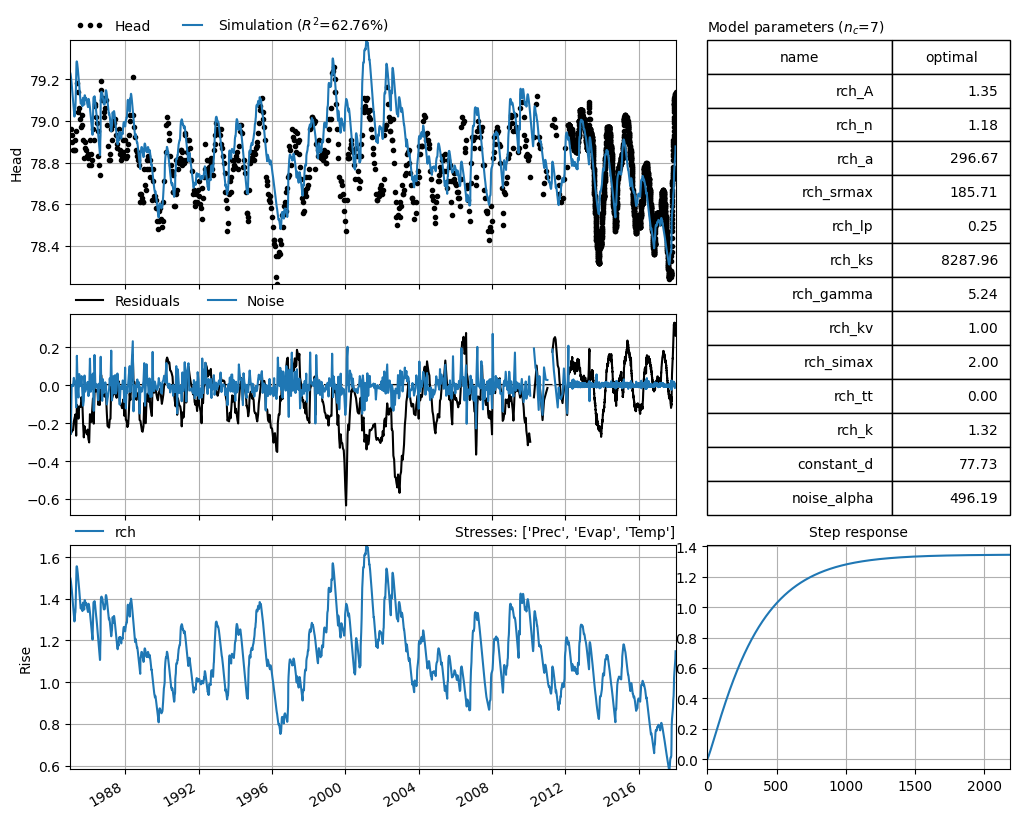

In [12]:
ml.plots.results();

## Important Notes

<div class="alert alert-warning" role="alert">
<strong>Cache Invalidation:</strong> The cache does not automatically detect when you modify stress data or response function settings. If you change these after creating a model, you must manually clear the cache using <code>stressmodel._cache.clear()</code>, or rebuild the stress model.
</div>

<div class="alert alert-info" role="note">
<strong>Cache Performance:</strong> The cache uses exact floating-point comparison for parameter values. During optimization, minor variations in parameter values (e.g., 1.0000000001 vs 1.0) create separate cache entries.
</div>

In normal workflows where you create a model, solve it, and use the results, cache invalidation is not an issue.

## Temporarily enabling or disabling caching

For operations where you know caching won't help, you can temporarily disable caching using the context manager:

In [13]:
with ps.temporarily_disable_cache():
    # Caching is disabled here
    print(f"Caching is temporarily:  {'enabled' if ps.get_use_cache() else 'disabled'}")
    params = ml.get_parameters()
    result = ml.simulate(params)

# Caching is automatically re-enabled after the block
print(f"Cache is now: {'enabled' if ps.get_use_cache() else 'disabled'}")

Caching is temporarily:  disabled
Cache is now: enabled


Or if you wish to temporarily enable caching:

In [ ]:
ps.set_use_cache(False)  # turn off caching

with ps.temporarily_enable_cache():
    # Caching is enable here
    print(f"Caching is temporarily:  {'enabled' if ps.get_use_cache() else 'disabled'}")
    params = ml.get_parameters()
    result = ml.simulate(params)

# Caching is automatically re-enabled after the block
print(f"Cache is now: {'enabled' if ps.get_use_cache() else 'disabled'}")


0
Caching is temporarily:  enabled
Cache is now: disabled


1